<a href="https://colab.research.google.com/github/HwayoungYoon/coin-analysis/blob/main/%EA%B0%9C%EB%B3%84%EC%9D%98_%EA%B0%80%EA%B2%A9_%EA%B7%B8%EB%9E%98%ED%94%84%EB%A1%9C_%EC%A0%84%EB%A7%9D_%EC%98%88%EC%B8%A1_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EA%B5%AC%EB%B6%84ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💰개별의 가격 그래프로 전망 예측하기📈

임의의 예시로 예측을 진행함

'파일 - 드라이브에 사본 저장' 후 저장된 사본에서 코드 수정해서 사용해주세유♥️

✨ **Tip!**
* 위에서부터 순서대로 실행
* 코드가 입력된 회색 박스 왼쪽 상단 ▶️ 버튼을 누르거나 박스 클릭 후 **Ctrl+Enter**를 누르면 실행됨
* 수정해서 사용해야할 부분들은 중간중간 있는 텍스트 중 '✅ **수정** ✅'이라고 써있는 부분을 참고
* 수정해야 할 코드는  중간중간 있는 텍스트 중 '✅ **수정** ✅'이라고 써있는 부분 중 아래와 같은 부분을 참고
```
요렇게 코드 박스랑 비슷하지만 들여쓰기가 되어있는 부분
```

* 결과에 대한 분석은 중간중간 있는 텍스트 중 '📌 **분석** 📌'이라고 써있는 부분을 참고

## 1. 코드 실행에 필요한 라이브러리 설치
* 맨처음 한 번만 실행
* 만약 아래 코드에 오류가 난다면 라이브러리 설치를 한 번 더 실행한 뒤 다시 아래 코드 실행

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

import requests
import time
from datetime import datetime
from tqdm import tqdm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

%matplotlib inline
warnings.filterwarnings('ignore')

## 2. 데이터 가져오기
✅ **수정** ✅
* 코드블록 맨 마지막에 있는 start_date, end_date, symbol의 값(빨간 글씨)만 수정하면 됨
* 예시 : 2017년 02월 01일부터 2022년 02월 01일까지 BTC/USDT의 데이터 가져오기
* **2017-02-01, 2022-02-01, BTCUSDT**를 원하는 값으로 수정
```
start_date = '2017-02-01'
end_date = '2022-02-01'
symbol = 'BTCUSDT'
```

In [2]:
result = requests.get('https://api.binance.com/api/v3/ticker/price')
js = result.json()

COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades', 
                   'tb_base_av', 'tb_quote_av', 'ignore']
URL = 'https://api.binance.com/api/v3/klines'
def get_data(start_date, end_date, symbol):
    data = []
    
    start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
    end = int(time.mktime(datetime.strptime(end_date +' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
    params = {
        'symbol': symbol,
        'interval': '1d',
        'limit': 1000,
        'startTime': start,
        'endTime': end
    }
    
    while start < end:
        print(datetime.fromtimestamp(start // 1000))
        params['startTime'] = start
        result = requests.get(URL, params = params)
        js = result.json()
        if not js:
            break
        data.extend(js)  # result에 저장
        start = js[-1][0] + 60000  # 다음 step으로
    # 전처리
    if not data:  # 해당 기간에 데이터가 없는 경우
        print('해당 기간에 일치하는 데이터가 없습니다.')
        return -1
    df = pd.DataFrame(data)
    df.columns = COLUMNS
    df['Open_time'] = df.apply(lambda x:datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
    df = df.drop(columns = ['Close_time', 'ignore'])
    df['Symbol'] = symbol
    df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
    df['trades'] = df['trades'].astype(int)
    return df

start_date = '2017-02-01'
end_date = '2022-02-01'
symbol = 'BTCUSDT'
df = get_data(start_date, end_date, symbol)

2017-02-01 00:00:00
2020-05-12 00:01:00
2022-02-01 00:01:00


**데이터가 잘 가져와졌는지 확인**
* 가져온 데이터의 처음과 끝 위주로 보여줌
* 바이낸스에 2017년 08월 17일 이전 데이터는 없는 것 같음

In [3]:
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,616.248541,2.678216e+06,BTCUSDT
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,972.868710,4.129123e+06,BTCUSDT
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,274.336042,1.118002e+06,BTCUSDT
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,376.795947,1.557401e+06,BTCUSDT
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,557.356107,2.255663e+06,BTCUSDT
...,...,...,...,...,...,...,...,...,...,...,...
1625,2022-01-28,37160.11,38000.00,36155.01,37716.56,42154.269560,1.560204e+09,1061101,21496.475510,7.958478e+08,BTCUSDT
1626,2022-01-29,37716.57,38720.74,37268.44,38166.84,26129.496820,9.896524e+08,816601,13292.421560,5.036245e+08,BTCUSDT
1627,2022-01-30,38166.83,38359.26,37351.63,37881.76,21430.665270,8.127502e+08,698593,10798.384600,4.096207e+08,BTCUSDT
1628,2022-01-31,37881.75,38744.00,36632.61,38466.90,36855.245800,1.386755e+09,936014,18422.269540,6.933600e+08,BTCUSDT


## 3. 데이터 전처리
분석을 위해 Open, High, Low, Close 평균을 낸 Mean 열 생성

In [4]:
df["Mean"] = (df['Open'] + df['High'] + df['Low'] + df['Close'])/4
df

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol,Mean
0,2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,3.454770e+06,3427,616.248541,2.678216e+06,BTCUSDT,4308.1725
1,2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,5.086958e+06,5233,972.868710,4.129123e+06,BTCUSDT,4175.9350
2,2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,1.549484e+06,2153,274.336042,1.118002e+06,BTCUSDT,4070.7600
3,2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,1.930364e+06,2321,376.795947,1.557401e+06,BTCUSDT,4112.7425
4,2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2.797232e+06,3972,557.356107,2.255663e+06,BTCUSDT,4029.1350
...,...,...,...,...,...,...,...,...,...,...,...,...
1625,2022-01-28,37160.11,38000.00,36155.01,37716.56,42154.269560,1.560204e+09,1061101,21496.475510,7.958478e+08,BTCUSDT,37257.9200
1626,2022-01-29,37716.57,38720.74,37268.44,38166.84,26129.496820,9.896524e+08,816601,13292.421560,5.036245e+08,BTCUSDT,37968.1475
1627,2022-01-30,38166.83,38359.26,37351.63,37881.76,21430.665270,8.127502e+08,698593,10798.384600,4.096207e+08,BTCUSDT,37939.8700
1628,2022-01-31,37881.75,38744.00,36632.61,38466.90,36855.245800,1.386755e+09,936014,18422.269540,6.933600e+08,BTCUSDT,37931.3150


## 4. 데이터 분석
참고 : https://teddylee777.github.io/data_science/prophet-stock-forecast

**전반적인 가격 흐름 확인을 위해 Mean 값으로 그린 그래프**

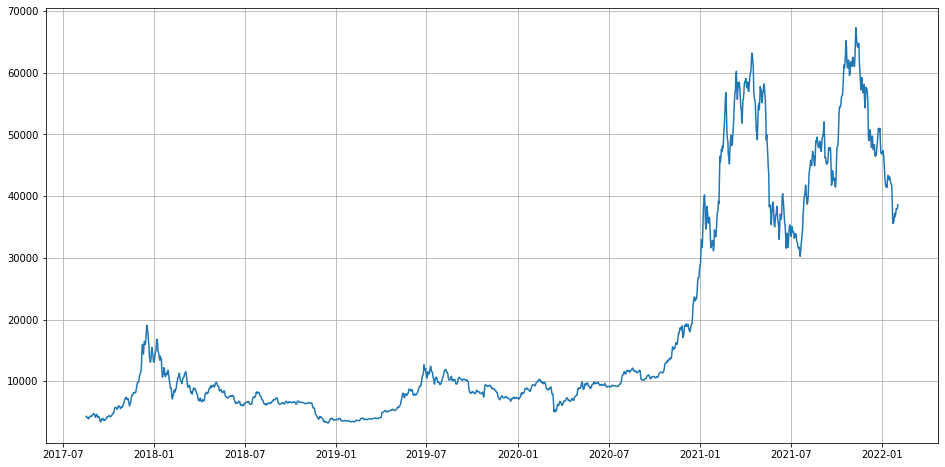

In [34]:
plt.figure(figsize=(16, 8))
plt.plot(df['Open_time'], df['Mean'])
plt.grid(True)

**예측을 위해 일부 값(전체 데이터의 20%)을 제거한 데이터 생성**
* 전체 데이터의 80%는 예측을 위한 자료로, 20%는 예측이 얼마나 정확한지 테스트하기 위해 사용

✅ **수정** ✅
* 코드블록 내 : 바로 뒤 숫자(청록색 글씨)만 수정하면 됨
* 예시 : 총 1630행을 가지는 데이터에 대해 80%에 해당하는 1304행까지만 가지도록 데이터 생성
* **1304**를 원하는 값으로 수정

```
df_trunc = df[:1304]
```

In [20]:
df_trunc = df[:1304]
df_trunc.tail()

,Open_time,Open,High,Low,Close,Volume,quote_av,trades,tb_base_av,tb_quote_av,Symbol,Mean
1299,2021-03-08,50959.11,52402.78,49274.67,52375.17,66987.359664,3.400848e+09,1999401,33595.429570,1.706118e+09,BTCUSDT,51252.9325
1300,2021-03-09,52375.18,54895.00,51789.41,54884.50,71656.737076,3.861451e+09,2194398,35011.541086,1.886845e+09,BTCUSDT,53486.0225
1301,2021-03-10,54874.67,57387.69,53005.00,55851.59,84749.238943,4.700198e+09,2647284,42651.887405,2.366856e+09,BTCUSDT,55279.7375
1302,2021-03-11,55851.59,58150.00,54272.82,57773.16,81914.812859,4.612366e+09,2509970,40603.449668,2.288705e+09,BTCUSDT,56511.8925
1303,2021-03-12,57773.15,58081.51,54962.84,57221.72,73405.406047,4.162055e+09,2489931,35802.941462,2.030616e+09,BTCUSDT,57009.8050


**예측을 위해 데이터 형식 변경**
* Prophet의 형식이 'ds', 'y'이므로 해당 열로 df_mean 데이터 프레임 만들기
* ds : 날짜 정보
* y : 가격 정보 (현재는 Open, High, Low, Close의 평균값인 Mean)

In [21]:
df_mean = pd.DataFrame({
    'ds' : df_trunc['Open_time'], 
    'y' : df_trunc['Mean']
})
df_mean.head()

,ds,y
0,2017-08-17,4308.1725
1,2017-08-18,4175.9350
2,2017-08-19,4070.7600
3,2017-08-20,4112.7425
4,2017-08-21,4029.1350


**예측을 위해 Facebook Prophet 모델 적용**
* 페이스북이 만든 시계열 예측 라이브러리 Prophet에 데이터를 넣어 모델 적용
* 연간 계절성, 주간 계절성을 고려하여 모델 적용

In [22]:
model = Prophet()
model.yearly_seasonality=True
model.weekly_seasonality=True
model.fit(df_mean)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**적용한 모델을 기반으로 예측한 데이터 생성**
* 전체 데이터의 80%는 예측을 위한 자료로, 20%는 예측이 얼마나 정확한지 테스트하기 위해 사용
* 기존 데이터의 20%가 추가된 데이터 프레임 future 생성
* ds : 날짜 정보
* yhat : 예측된 가격 정보
* yhat_lower : 예측된 가격의 하한값
* yhat_upper : 예측된 가격의 상한값

✅ **수정** ✅
* 코드블록 내 periods 값 숫자(청록색 글씨)만 수정하면 됨
* 예시 : 총 1630행을 가지는 데이터에 대해 20%에 해당하는 326개의 데이터 생성
* **326**를 원하는 값으로 수정

```
future = model.make_future_dataframe(periods=326)
```

In [23]:
future = model.make_future_dataframe(periods=326)
forecast = model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-08-17,5189.957663,3532.755715,6937.864279
1,2017-08-18,5139.730792,3449.341852,7043.761715
2,2017-08-19,5113.642539,3491.644648,6767.540281
3,2017-08-20,5042.617486,3098.014974,6827.230151
4,2017-08-21,4987.151479,3168.260516,6626.141247


**예측 결과 시각화**
* 연간 계절성, 주간 계절성을 고려했기 때문에 전체적인 추세와 함께 연간 추세와 주간 추세를 확인
* 반응형 그래프로 그래프에 마우스를 가져다대면 해당 지점의 상세한 값을 볼 수 있음


* 첫 번째 그래프 : 전체 추세, 예측된 값
* 두 번째 그래프 : 연간 추세, 1월부터 12월까지의 가격 변동 추세 확인
* 세 번째 그래프 : 주간 추세, 일요일부터 토요일까지의 가격 변동 추세 확인


📌 **분석** 📌
* **2020년 7월 이후 증가하는 추세를 보임**
* **5월 말 ~ 6월 초에 가격이 높은편, 10월 말 ~ 11월 초에 가격이 낮은 편으로 보임**
* **목요일과 토요일에 가격이 높은편(목요일이 약간 더 높은편), 월요일에 가격이 낮은 편으로 보임**

In [24]:
plot_components_plotly(model, forecast)

**예측의 상한선과 하한선을 포함한 예측 결과 그래프**
* 예측에 사용된 전체 데이터의 80%에 해당하는 값은 검정색 점으로, 예측된 값은 파란 실선으로 그려진 그래프
* 파란 실선 주위의 하늘색 영역은 예측의 하한값부터 상한값까지를 표시한 부분


* 아래 두 그래프는 같은 그래프이지만 두 번째 그래프는 반응형 그래프
* 반응형 그래프에 그래프에 마우스를 가져다대면 해당 지점의 상세한 값을 볼 수 있음
* 반응형 그래프 하단 상자 가장자리 막대로 범위를 조절해서 볼 수 있음


📌 **분석** 📌
* **실제값과 예측된 값이 거의 비슷해보임**
* **실제값이 없는 부분의 하한부터 상한까지의 범위가 꽤 넓으므로 예측값의 신뢰도가 떨어진다고 볼 수 있음**

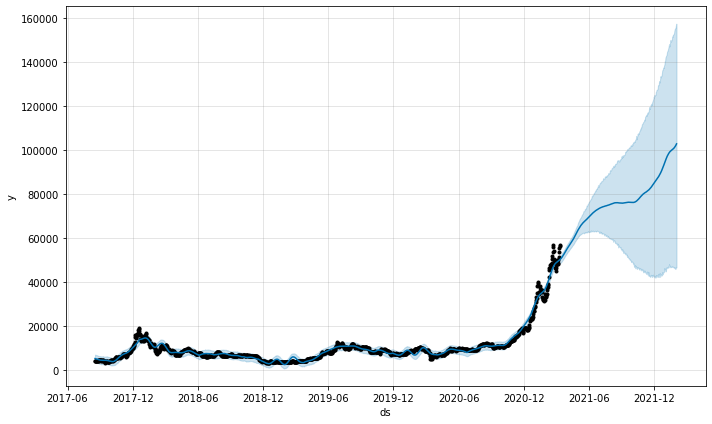

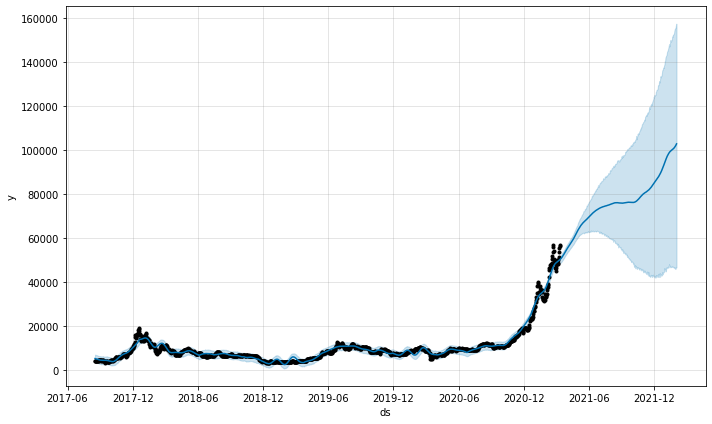

In [25]:
# 기본 그래프
model.plot(forecast)

In [26]:
# 반응형 그래프
plot_plotly(model, forecast)

**예측값과 실제값을 비교하는 그래프**
* 예측값은 주황 실선으로, 실제값은 파란 실선으로 그려진 그래프

📌 **분석** 📌
* **실제값이 있던 2021년 3월까지는 실제값과 매우 유사함**
* **2021년 3월 이후 값의 차이가 심하게 나는데 이는 가격 외의 요인이 작용했다고 보여짐**

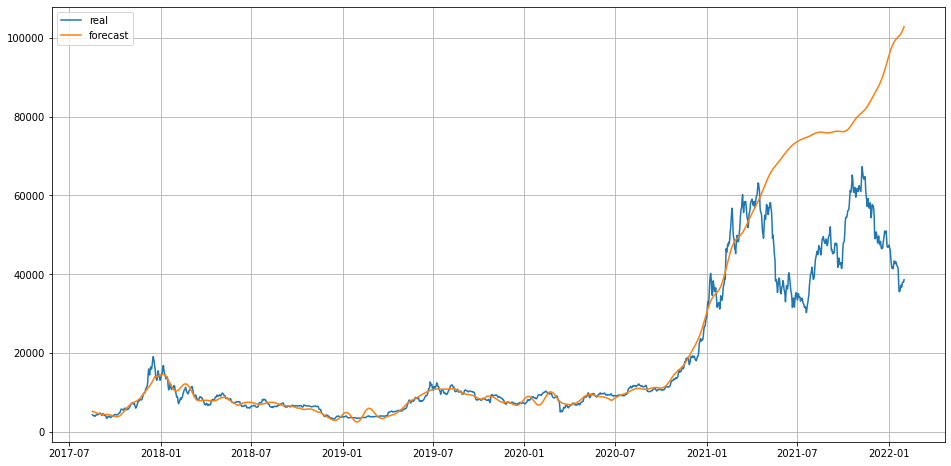

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(df['Open_time'], df['Mean'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label = 'forecast')
plt.grid(True)
plt.legend()
plt.show()

**change points를 포함한 예측 그래프**
* change points는 가격 변동이 큰 구간
* 그래프 위에 그려진 빨간 수직선으로 어느 시점에서 가격 변동이 주로 일어났는지 확인
* 외부 요인과 change points의 일치 정도를 확인해봐도 좋을 것 같음

[[<matplotlib.lines.Line2D at 0x7f4a6bb2f4d0>],

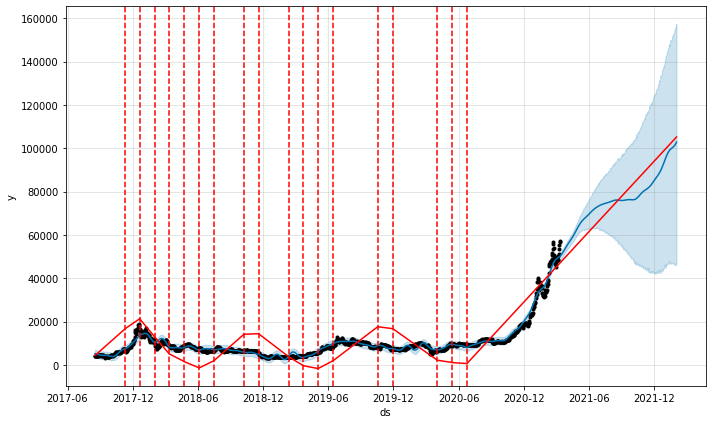

In [28]:
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)

**예측 정확도 평가를 위한 값**
* MSE, RMSE, MAE 값을 이용해 모델의 정확도 평가 가능
* 원래 기능은 같은 데이터에 여러 가지의 모델을 적용했을 때 어떤 모형이 가장 예측을 잘 하는지 평가하기 위해 사용
* 다른 데이터에 대해 같은 모델을 적용했을 때(우리의 경우)는 대략적으로 참고만 하면 좋을 것 같음


* MSE, RMSE, MAE 값이 낮을수록 예측을 잘 했다고 평가
* RMSE는 MSE 값에 루트 씌운 값으로 MSE 값이 너무 커서 그냥 하나 넣어봄

In [30]:
# MSE, MAE는 낮을 수록 상대적으로 더 좋은 모델
mse = MSE(df["Mean"], forecast['yhat'])
rmse = np.sqrt(MSE(df["Mean"], forecast['yhat']))
mae = MAE(df["Mean"], forecast['yhat'])

print("MSE : ", mse)
print("RMSE : ", rmse)
print("MAE : ", mae)

MSE :  217049448.46002617
RMSE :  14732.598157148866
MAE :  6498.899754353215


## 5. 개선할 점
* **데이터 분할** : 현재 분석은 데이터를 8:2로 나누어 일부 데이터는 사용하지 않고 예측을 진행함. 그러나 BTC의 경우 실제값과 예측값의 차이가 심하여 데이터를 나누지 않고 전체 데이터를 사용한 뒤 찐 미래(아직 안 온 내일, 모레, 그 이후 등등)에 대해서만 예측을 진행해도 될 것 같음. 오히려 이 편이 더 정확한 예측이 가능할 수도 있을 것 같음.
* **계절성 고려** : 계절성을 고려할 필요가 있을까에 대한 의문. 요일이나 월에 따라 비슷한 추세가 반복된다면 계절성 고려가 필요하지만 그렇지 않다면 굳이 계절성 고려는 필요 없을 것 같음. 계절성 고려가 필요없다면 약간의 코드 수정이 필요함.
* **flexibility 조절** : 좀 더 정확한 예측을 위해 조절하면 좋을 값이지만 여러 개의 종목 중 1차적으로 거르는 목적으로 사용한다면 굳이 사용할 필요가 없을 것 같아서 우선 제외하고 예측 진행함. 종목이 어느정도 확정된 이후 자세한 분석이 들어갈 때 적용할 예정.
* **ARIMA, LSTM 등 다양한 모델 적용** : 위와 마찬가지로 종목이 어느정도 확정된 이후 자세한 분석이 들어갈 때 적용하여 가장 예측 정확도가 높은 모델을 적용할 예정.